# Welcome to an example Binder

This notebook uses `seaborn`, which we have because we included it in our `requirements.txt` file

## Setup our plotting

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Setup our imports

In [3]:
from pyproj import Geod
import geojson

In [4]:
sites = {
    'CORK 1364A' : {'lon' : -126.872152, 'lat': 48.699937, 'depth': 1317.7},
}

## Setup pyproj
[see](http://pyproj4.github.io/pyproj/html/api/geod.html)


In [ ]:
g = Geod(ellps='WGS84')
s = sites['CORK 1364A']



# Plate motion
Plate motions are calculated using [UNAVCO Plate Motion Calculator](https://www.unavco.org/software/geodetic-utilities/plate-motion-calculator/plate-motion-calculator.html)

Input coordinates:

    -127.157 48.25721 -2500 #1,
    -127.639 48.79599 -2500 #8,
    -126.8722 48.6999 1200 CORK 1364A,
    -126.1733 48.4278 400 BC-US,
    -125.8918 49.2267 0 CQS-Shore,
    -127.345 48.90984 -1200 #9

* Model GSRM 2.1 (2014)
* Plate motion (JdF)
* Relative to NA

Results:

    -127.157000  48.257210   31.61   26.59 0 0 0 JF(NA) GSRM v2.1 #1
    -127.639000  48.795990   32.56   27.45 0 0 0 JF(NA) GSRM v2.1 #8
    -126.872200  48.699900   32.65   26.09 0 0 0 JF(NA) GSRM v2.1 CORK 1364A
    -126.173300  48.427800   32.31   24.83 0 0 0 JF(NA) GSRM v2.1 BC-US
    -125.891800  49.226700   34.06   24.32 0 0 0 JF(NA) GSRM v2.1 CQS-Shore
    -127.345000  48.909840   32.91   26.93 0 0 0 JF(NA) GSRM v2.1 #9




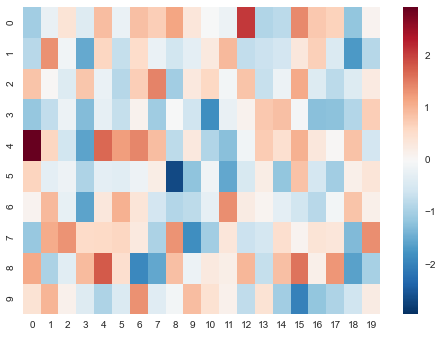

In [4]:
n_start = g.fwd()